# Proteomic Analyses Continued

This document will take you through plotting proteomic data.

## (0) Setup

1. Set your working director.
2. Import cptac, numpy (np), and pandas (pd).
3. Download the Brca dataset
4. Extract the clinical, transcriptomic, and proteomic dataframes from the Brca object

In [1]:
# set your working director to analysis data
import os
os.chdir('../week10_proteomics/analysis_data/')

# import cptac, numpy, and pandas
import cptac
import numpy as np
import pandas as pd

# download the Brca dataset
cptac.download(dataset="Brca")
brca = cptac.Brca()

# extract the data
clinical_data = brca.get_clinical()
transcriptomic_data = brca.get_transcriptomics()
protein_data = brca.get_proteomics()
protein_data.columns = protein_data.columns.get_level_values(0) 
protein_data.columns

Index(['A1BG', 'A2M', 'A2ML1', 'AAAS', 'AACS', 'AADAT', 'AAED1', 'AAGAB',
       'AAK1', 'AAMDC',
       ...
       'ZSCAN31', 'ZSWIM8', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='Name', length=10107)

## (1) Plotting with matplotlib

Let's explore some more complex ways to plot using the Matplotlib package.

Import pyplot from matplotlib as its common handle (plt)

In [2]:
# Write code here
import matplotlib.pyplot as plt

Let's explore how the proteomic expression of a gene differs between young and old patients.

**Exercise 1.1** Plot the expression data of a chosen protein stratified between young ($\lt$50) and old ($\ge$ 50) patients.

In [3]:
young_mask = clinical_data.loc[:, "Age.in.Month"] / 12 < 50
old_mask = clinical_data.loc[:, "Age.in.Month"] / 12 >= 50

young = (protein_data.loc[young_mask, "ZW10"]).dropna() # the age column is 'Age.in.Month', which (as stated) is in months
old = (protein_data.loc[old_mask, "ZW10"]).dropna()

data = [old.values, young.values] # our boxplot function will require an array (or an array of arrays)
data

[array([-0.301 , -0.6686,  0.9199,  1.047 , -0.5334,  0.4307, -0.5136,
        -0.2318, -0.6577, -0.0591, -0.2606,  0.0141, -0.6064, -0.3294,
         0.8799, -1.0045,  0.066 ,  0.3576, -0.181 ,  0.7229,  0.5198,
         0.2022,  0.2009, -0.3551, -0.1458,  0.9153, -0.6368, -0.1421,
         0.8214, -0.2956,  0.0448, -0.2002, -0.6068, -0.6488,  1.4808,
        -1.1428, -0.9939,  0.256 , -0.0727, -0.8884, -0.4302, -0.0471,
         0.532 ,  1.3067,  1.132 ,  0.0839,  1.1183,  0.1764, -0.2882,
        -0.4734,  0.0834,  0.474 , -0.7866,  0.1993,  0.6589,  1.2561,
        -0.5604, -0.191 ,  0.2566,  0.1905,  0.2575, -0.7812, -0.2273,
        -0.7848, -0.4266,  0.8718,  0.2822,  0.4937,  0.3147,  0.0086,
        -0.6933,  0.7744,  0.889 ,  0.2906, -0.4804,  0.1229,  0.207 ,
        -0.7937,  1.011 ,  0.9049,  0.885 ,  1.0655]),
 array([-0.3979, -0.0702, -0.2901, -1.2361, -0.1107,  0.626 ,  0.2125,
        -0.2169,  0.759 ,  0.1474, -0.2297,  0.2176, -0.0501,  0.6383,
         0.4003, -0.77

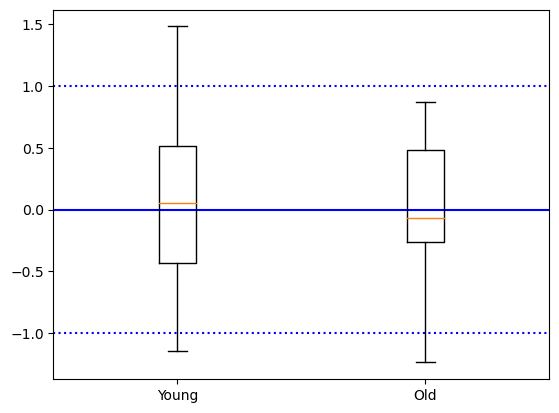

In [4]:
fig, ax = plt.subplots()

plt.axhline(y = 0, color = 'blue', linestyle = '-')
plt.axhline(y = -1, color = 'blue', linestyle = ':')
plt.axhline(y = 1, color = 'blue', linestyle = ':')


bp = ax.boxplot(data) # data goes here
plt.xticks([1, 2], ["Young", "Old"]) # use \n for new line if desired


plt.show()

**Exercise 1.2** Why do you think we added lines at -1, 0, and 1? What do these values represent in terms of log2FoldChange?

In [5]:
# answer in a comment here
#We added the lines to denote relative expression levels since -1 corresponds to a 
#2^-1 = 0.5-fold change, 0 corresponds to a 1-fold change (same relative expression)
# and 1 corresponds to a 2-fold change in expression

## (2) SciPy

Another question to ask is if the levels of RNA expression correlate with protein expression. While we would expect for there to be a 1:1 relationship between RNA and protein (according to the central dogma), as you will see, this is not what we oftentimes observe.

In [6]:
from scipy import stats # we are using the stats package in particular

The first thing we need to do is to identify which patients and genes are shared between the transcriptomic and proteomic data sets.

Luckily for us, all 122 patients in the Brca dataset have clinical, transcriptomic, and proteomic data. If this were not the case (such as in the colon cancer database), we would use `intersect1d()` to fix this. We will still need to use `intersect1d()` to determine which genes are shared.

**Exercise 2.1** To make sure the data frames match:

1. Identify the names of the genes that are shared between the two datasets (hint: use `intersect1d()`). Is this data the row or column names? Column 
2. Create the rna_shared and prot_shared data frames; ie dataframes with only genes that are shared between rna and protein data. (Hint: how can we access rows/columns by name?).

In [7]:
# 1. Identify the genes (RNA, protein) shared between the two data sets 
shared_rna_prot = np.intersect1d(transcriptomic_data.columns, protein_data.columns)

# 2. Create the two data frames
rna_shared = transcriptomic_data[shared_rna_prot]
prot_shared = protein_data[shared_rna_prot]

shared_rna_prot

array(['A1BG', 'A2M', 'A2ML1', ..., 'ZYX', 'ZZEF1', 'ZZZ3'], dtype=object)

Now, we can see how correlated the RNA and protein levels are. We'll use Spearman correlation from the stats library, which is `spearmanr()`. 

**Exercise 2.2** Choose a gene and get the Spearman correlation of the rna to protein of that gene.

In [8]:
# we need the nan_policy="omit" to throw out NaN values
corr, pval = stats.spearmanr(rna_shared["ZZZ3"], prot_shared["ZZZ3"], nan_policy="omit")

print(f"The correlation of ZZZ3 is {round(corr, 3)} (p = {round(pval, 10)}).")

The correlation of ZZZ3 is 0.401 (p = 4.6754e-06).


**Exercise 2.3** What is your gene's Spearman correlation? What does that mean mathematically? What could this represent biologically? Look into the literature to see if it corroborates this idea.

In [9]:
# answer in a comment here
#The Spearman correlation for ZZZ3 is 0.401, which mathematically indicates
#a weak to moderate strength correlation between the expression of this gene
#RNA and protein expression levels. Biologically, we may infer that ZZZ3 is 
#potentially either a coding gene since the correlation value is nearing a moderate value. 
#Literature gives us the clue that it is a coding gene responsible for
#a protein involved in H4 histone acetylation. 

## (3) Heatmaps
**Exercise 3.1** A problem arises if we want to compare many correlations. Heatmaps are useful for visualizing a large number of comparisons. To make a heatmap, we'll use the `heatmap()` function from seaborn. Let's do the following:

1. Set up our data frame to hold all comparisons. All you need to do is to access the first 20 gene names.
2. Calculate the correlations for the first 20 genes (just to save time). You'll need to use two for loops.
3. Call `clustermap()` -- this is filled in for you!
4. Interpret the data. There is a "light" diagonal along the heatmap from the top-left to bottom-right. Is this expected? Why or why not?

In [10]:
import seaborn as sns

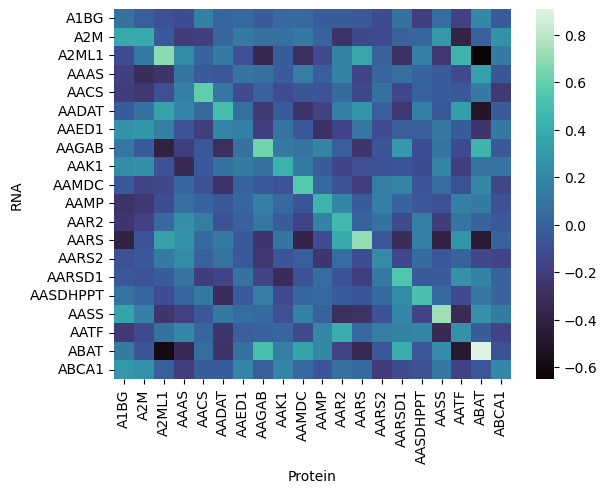

In [11]:
ncomparisons = 20 # define this variable in case we want to change the number of correlations to test
                  # this makes it less likely you'll forget to change a number, e.g. in the data frame shape
gene_names = protein_data.columns[0:ncomparisons] # get the first ncomparisons gene names


# Don't worry about this code
# It's good practice to declare your data frame beforehand (it's much faster than appending to a list)
# We fill everything in with 0 just as a placeholder
corr_df = pd.DataFrame(np.ndarray(shape=(ncomparisons, ncomparisons), dtype=np.float16),
                      index = gene_names,
                      columns = gene_names)

# 2. fill in the data frame!
for g1 in gene_names:
    for g2 in gene_names:
        # calculate the correlations between protein and RNA
        # then, use .loc[] to store the correlation in corr_df
        corr, pval = stats.spearmanr(rna_shared[g1], prot_shared[g2], nan_policy="omit")
        corr_df.loc[g1, g2] = corr

# 3. create the heat map
plot = sns.heatmap(
    corr_df,  
    cmap='mako',
)
plot.set_xlabel('Protein', fontsize=10)
plot.set_ylabel('RNA', fontsize=10)
plt.show()

# 4. interpret!
#There is a fairly evenly spread distribution of correlations, ranging from
#strong negative correaltions denoted by black squares to strong positive
#correlations denoted by light green scores (predominant across diagonal 
#since RNA-Protein expression levels are likely to be similar for the same
#gene.

## (4) Plotting with Seaborn

`seaborn` is a nice package that makes prettier plots with more control over the figure.

Here's how you make a scatter plot with seaborn, for example:

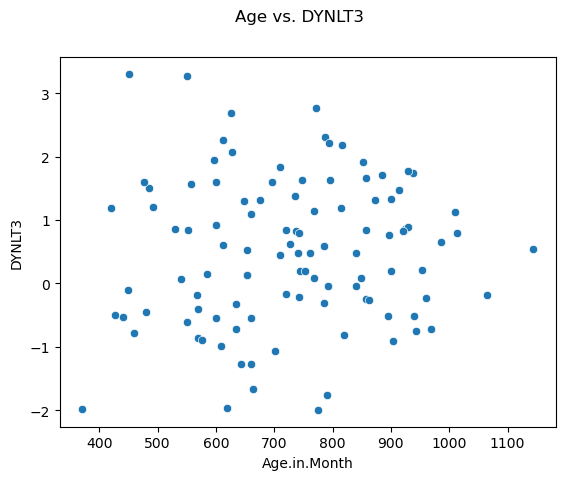

In [12]:
fig, ax = plt.subplots()

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age.in.Month"],
    y = protein_data.loc[:, "DYNLT3"],# y-axis
    legend = "full",  # show the legend
    ax = ax  # necessary for when plotting more than 1 subplot
)

fig.suptitle('Age vs. DYNLT3')  # set title

plt.show()

**Exercise 4.1** Update the above plot to:
1. Have age in years instead of months.
2. Color patients based on gender (or another clinical variable of your choosing)
3. Have a side-by-side second plot with a different protein of your choosing

NOTE: you will need to Google to figure out how to do most of the above things!

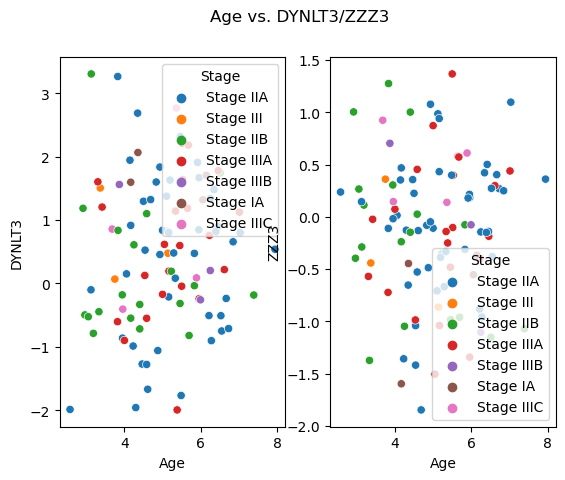

In [15]:
# create plot here
fig, ax = plt.subplots(1,2)

clinical_data["Age"] = clinical_data.loc[:, "Age.in.Month"] / 12

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age"] / 12,
    y = protein_data.loc[:, "DYNLT3"],# y-axis
    legend = "full",  # show the legend
    ax = ax[0],  # necessary for when plotting more than 1 subplot
    hue = clinical_data["Stage"]
)

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age"] / 12,
    y = protein_data.loc[:, "ZZZ3"],# y-axis
    legend = "full",  # show the legend
    ax = ax[1],  # necessary for when plotting more than 1 subplot
    hue = clinical_data["Stage"]
)

fig.suptitle('Age vs. DYNLT3/ZZZ3')  # set title

plt.show()

## (5) Saving Plots

Finally, to save a plot, we can call `plt.savefig()` instead of the `plt.show()`.

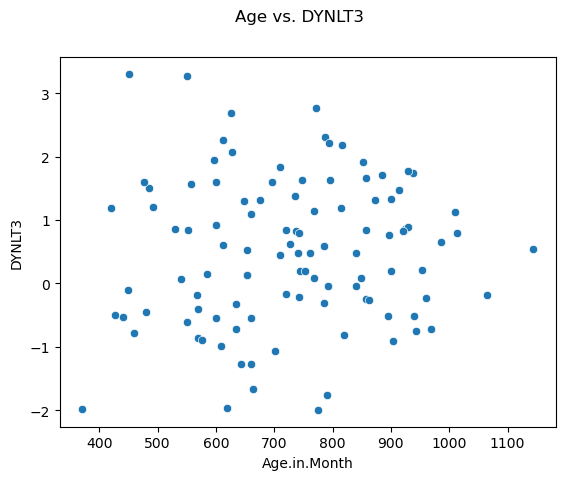

In [14]:
fig, ax = plt.subplots()

sns.scatterplot( # x-axis
    x = clinical_data.loc[:, "Age.in.Month"],
    y = protein_data.loc[:, "DYNLT3"],# y-axis
    legend = "full",  # show the legend
    ax = ax  # necessary for when plotting more than 1 subplot
)

fig.suptitle('Age vs. DYNLT3')  # set title

# age_scatter.png is a relative path so check your working directory before running it
plt.savefig('age_scatter.png', bbox_inches='tight')